In [1]:
import os
import glob
import cv2
import geopandas as gpd
import h5py # just a safety check so the checkpoint callback doesnt crash
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from scipy.misc import imresize
import shapely.geometry
import tensorflow as tf
print(tf.__version__)
import pandas as pd
from geopandas import GeoDataFrame

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

1.1.0


Read in csv with building footprints and convert the text to a geometries then polygons:

In [12]:
df_buildings = pd.read_csv('/home/vaston/Metis_Project_5/Las_Vegas_Pictures/AOI_2_Vegas_Train/summaryData/AOI_2_Vegas_Train_Building_Solutions.csv')
df_buildings.head()
# df_buildings_gpd = gpd.read_file('/home/vaston/Metis_Project_5/Las_Vegas_Pictures/AOI_2_Vegas_Train/summaryData/AOI_2_Vegas_Train_Building_Solutions.csv')
# df_buildings_gpd.head()

,ImageId,BuildingId,PolygonWKT_Pix,PolygonWKT_Geo
0,AOI_2_Vegas_img1209,1,"POLYGON ((68.71 623.1 0,35.71 618.15 0,33.59 6...","POLYGON ((-115.27398708 36.20208033800003 0,-1..."
1,AOI_2_Vegas_img1209,2,"POLYGON ((221.33 645.02 0,185.7 640.33 0,184.4...",POLYGON ((-115.273575016999985 36.202021143000...
2,AOI_2_Vegas_img1209,3,"POLYGON ((150.3 650.0 0,160.9 650.0 0,150.58 6...",POLYGON ((-115.273766779991007 36.202007699876...
3,AOI_2_Vegas_img1209,4,"POLYGON ((141.86 636.02 0,98.99 630.03 0,99.57...",POLYGON ((-115.273789578999981 36.202045452000...
4,AOI_2_Vegas_img1209,5,"POLYGON ((227.4 650.0 0,240.73 650.0 0,227.69 ...",POLYGON ((-115.273558615661273 36.202007699876...


In [13]:
df_buildings = df_buildings.drop(['PolygonWKT_Pix'],axis=1)
#df_buildings = df_buildings.rename(columns = {'PolygonWKT_Geo':'geometry'}) 
df_buildings.head()

,ImageId,BuildingId,PolygonWKT_Geo
0,AOI_2_Vegas_img1209,1,"POLYGON ((-115.27398708 36.20208033800003 0,-1..."
1,AOI_2_Vegas_img1209,2,POLYGON ((-115.273575016999985 36.202021143000...
2,AOI_2_Vegas_img1209,3,POLYGON ((-115.273766779991007 36.202007699876...
3,AOI_2_Vegas_img1209,4,POLYGON ((-115.273789578999981 36.202045452000...
4,AOI_2_Vegas_img1209,5,POLYGON ((-115.273558615661273 36.202007699876...


In [14]:
df_buildings['geometry'] = df_buildings['PolygonWKT_Geo']

In [15]:
df_buildings.tail()

,ImageId,BuildingId,PolygonWKT_Geo,geometry
110037,AOI_2_Vegas_img4107,4,POLYGON ((-115.202217599790103 36.211160967734...,POLYGON ((-115.202217599790103 36.211160967734...
110038,AOI_2_Vegas_img4107,5,POLYGON ((-115.202217599790103 36.211566416926...,POLYGON ((-115.202217599790103 36.211566416926...
110039,AOI_2_Vegas_img4107,6,POLYGON ((-115.202245993999952 36.212132067000...,POLYGON ((-115.202245993999952 36.212132067000...
110040,AOI_2_Vegas_img4107,7,POLYGON ((-115.203091813999947 36.212135405000...,POLYGON ((-115.203091813999947 36.212135405000...
110041,AOI_2_Vegas_img2131,1,POLYGON ((-115.246542082999952 36.175687279000...,POLYGON ((-115.246542082999952 36.175687279000...


In [16]:
type(df_buildings['geometry'].iloc[0])

str

Make a df copy so I dont mess up my df while cleaning the text....

In [34]:
df_buildings_test = df_buildings.copy()

In [35]:
for i in range(len(df_buildings_test)):    
#     try:
    text =df_buildings_test['geometry'].iloc[i] 
    points_text = text.split(' (')
    try:
        test_clean = points_text[1].replace("(",'').replace(')','').split(',')
    except:
        test_clean = ""
        print(i)
    coordinates = []
    for pair in test_clean:
        pair = pair.replace(' 0','')
        coordinates.append(pair)
    coordinates_num = []
    for points in coordinates:
        indiv_points = points.split(' ')
        points_list = []
        for loc in indiv_points:
            loc = float(loc)
            points_list.append(loc)
        points_list = tuple(points_list)
        coordinates_num.append(points_list)
    df_buildings_test['geometry'].iloc[i] = coordinates_num
#     except:
#         print(i)
#         df_buildings['geometry'].iloc[i] = ''

AttributeError: 'list' object has no attribute 'split'

In [38]:
df_buildings_test.tail()

,ImageId,BuildingId,PolygonWKT_Geo,geometry
110037,AOI_2_Vegas_img4107,4,POLYGON ((-115.202217599790103 36.211160967734...,"[(-115.2022176, 36.2111609677), (-115.20293974..."
110038,AOI_2_Vegas_img4107,5,POLYGON ((-115.202217599790103 36.211566416926...,"[(-115.2022176, 36.2115664169), (-115.20326127..."
110039,AOI_2_Vegas_img4107,6,POLYGON ((-115.202245993999952 36.212132067000...,"[(-115.202245994, 36.212132067), (-115.2022176..."
110040,AOI_2_Vegas_img4107,7,POLYGON ((-115.203091813999947 36.212135405000...,"[(-115.203091814, 36.212135405), (-115.2030594..."
110041,AOI_2_Vegas_img2131,1,POLYGON ((-115.246542082999952 36.175687279000...,"[(-115.246542083, 36.175687279), (-115.2464646..."


Pickle the df in this state:

In [2]:
import pickle

fileObject = open('df_buildings_geo_pickle.p')  
# load the object from the file into var b
test_data = pickle.load(fileObject)  
test_data.head()

,ImageId,BuildingId,PolygonWKT_Geo,geometry
0,AOI_2_Vegas_img1209,1,"POLYGON ((-115.27398708 36.20208033800003 0,-1...","[(-115.27398708, 36.202080338), (-115.27400379..."
1,AOI_2_Vegas_img1209,2,POLYGON ((-115.273575016999985 36.202021143000...,"[(-115.273575017, 36.202021143), (-115.2735777..."
2,AOI_2_Vegas_img1209,3,POLYGON ((-115.273766779991007 36.202007699876...,"[(-115.27376678, 36.2020076999), (-115.2737660..."
3,AOI_2_Vegas_img1209,4,POLYGON ((-115.273789578999981 36.202045452000...,"[(-115.273789579, 36.202045452), (-115.2737976..."
4,AOI_2_Vegas_img1209,5,POLYGON ((-115.273558615661273 36.202007699876...,"[(-115.273558616, 36.2020076999), (-115.273557..."


In case I need to reload the pickle file:

In [4]:
import pickle

fileObject = open('df_buildings_geo_pickle.p')  
# load the object from the file into var b
test_data = pickle.load(fileObject)  
test_data.head()

,ImageId,BuildingId,PolygonWKT_Geo,geometry
0,AOI_2_Vegas_img1209,1,"POLYGON ((-115.27398708 36.20208033800003 0,-1...","[(-115.27398708, 36.202080338), (-115.27400379..."
1,AOI_2_Vegas_img1209,2,POLYGON ((-115.273575016999985 36.202021143000...,"[(-115.273575017, 36.202021143), (-115.2735777..."
2,AOI_2_Vegas_img1209,3,POLYGON ((-115.273766779991007 36.202007699876...,"[(-115.27376678, 36.2020076999), (-115.2737660..."
3,AOI_2_Vegas_img1209,4,POLYGON ((-115.273789578999981 36.202045452000...,"[(-115.273789579, 36.202045452), (-115.2737976..."
4,AOI_2_Vegas_img1209,5,POLYGON ((-115.273558615661273 36.202007699876...,"[(-115.273558616, 36.2020076999), (-115.273557..."


In [5]:
df_buildings_test = test_data.copy()
df_buildings_test.geometry[512] 

[]

Replace any blank cells with a np.nan:

In [6]:
#df_buildings_test['geometry'].replace([],'')
df_buildings_test.geometry = df_buildings_test.geometry.apply(lambda y: np.nan if len(y)==0 else y)

In [7]:
df_buildings_test.geometry[512]

nan

In [8]:
len(df_buildings_test)

110042

Then drop them:

In [9]:
df_buildings_test_na = df_buildings_test.dropna()
len(df_buildings_test_na)

109807

Make geometries with shapely:

In [10]:
geo_df_buildings = df_buildings_test_na.set_geometry(df_buildings_test_na.geometry.apply(shapely.geometry.Polygon))


In [11]:
geo_df_buildings

,ImageId,BuildingId,PolygonWKT_Geo,geometry
0,AOI_2_Vegas_img1209,1,"POLYGON ((-115.27398708 36.20208033800003 0,-1...","POLYGON ((-115.27398708 36.20208033800003, -11..."
1,AOI_2_Vegas_img1209,2,POLYGON ((-115.273575016999985 36.202021143000...,"POLYGON ((-115.273575017 36.20202114300002, -1..."
2,AOI_2_Vegas_img1209,3,POLYGON ((-115.273766779991007 36.202007699876...,"POLYGON ((-115.273766779991 36.2020076998767, ..."
3,AOI_2_Vegas_img1209,4,POLYGON ((-115.273789578999981 36.202045452000...,"POLYGON ((-115.273789579 36.20204545200005, -1..."
4,AOI_2_Vegas_img1209,5,POLYGON ((-115.273558615661273 36.202007699876...,"POLYGON ((-115.2735586156613 36.2020076998767,..."
5,AOI_2_Vegas_img1209,6,POLYGON ((-115.27417259993355 36.2025144913411...,POLYGON ((-115.2741725999336 36.20251449134115...
6,AOI_2_Vegas_img1209,7,POLYGON ((-115.273968876999959 36.202492435000...,"POLYGON ((-115.273968877 36.20249243500007, -1..."
7,AOI_2_Vegas_img1209,8,POLYGON ((-115.272754125999938 36.202167611000...,POLYGON ((-115.2727541259999 36.20216761100005...
8,AOI_2_Vegas_img1209,9,POLYGON ((-115.273366127999964 36.202400240000...,"POLYGON ((-115.273366128 36.20240024000003, -1..."
9,AOI_2_Vegas_img1209,10,POLYGON ((-115.273156992999986 36.202357965000...,"POLYGON ((-115.273156993 36.20235796500003, -1..."


Check that the geomteries are in the correct format:

In [12]:
type(geo_df_buildings.geometry[1000])

shapely.geometry.polygon.Polygon

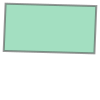

In [13]:
geo_df_buildings.geometry[1000]

In [14]:
len(geo_df_buildings)

109807

In [17]:
geo_df_buildings_f =geo_df_buildings.drop('PolygonWKT_Geo', axis = 1)

In [18]:
geo_df_buildings_f.head()

,ImageId,BuildingId,geometry
0,AOI_2_Vegas_img1209,1,"POLYGON ((-115.27398708 36.20208033800003, -11..."
1,AOI_2_Vegas_img1209,2,"POLYGON ((-115.273575017 36.20202114300002, -1..."
2,AOI_2_Vegas_img1209,3,"POLYGON ((-115.273766779991 36.2020076998767, ..."
3,AOI_2_Vegas_img1209,4,"POLYGON ((-115.273789579 36.20204545200005, -1..."
4,AOI_2_Vegas_img1209,5,"POLYGON ((-115.2735586156613 36.2020076998767,..."


In [19]:
pwd

u'/home/vaston/Metis_Project_5/Las_Vegas_Pictures/AOI_2_Vegas_Train'

Make geojson file with building footprints:

In [21]:
output_file_name = 'building_fooprints_f.geojson'

# Make sure the file doesnt exist (the program will crash if it does)
if os.path.exists(output_file_name):
    os.remove(output_file_name)

# Save the file as a geojson
geo_df_buildings_f.to_file(output_file_name, driver='GeoJSON')

Check what they look like on the map:

In [23]:
geo_df_buildings_plot = geo_df_buildings_f.copy()

In [29]:
geo_df_buildings_plot_t = geo_df_buildings_plot.head(10000)

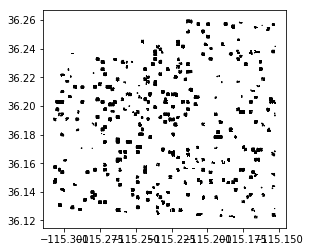

In [30]:
geo_df_buildings_plot_t.plot()

In [84]:
from shapely.geometry import Polygon
df_buildings.geometry = Polygon(df_buildings.geometry)


AssertionError: 

At some point I made this a geopandas df:

In [11]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

geo_df_buildings = GeoDataFrame(df_buildings)

And tested out how to get geometries from the text in the geometry column:

In [15]:
type(geo_df_buildings.geometry[1])

str

In [13]:
geo_df_buildings.head()

,ImageId,BuildingId,geometry
0,AOI_2_Vegas_img1209,1,"POLYGON ((-115.27398708 36.20208033800003 0,-1..."
1,AOI_2_Vegas_img1209,2,POLYGON ((-115.273575016999985 36.202021143000...
2,AOI_2_Vegas_img1209,3,POLYGON ((-115.273766779991007 36.202007699876...
3,AOI_2_Vegas_img1209,4,POLYGON ((-115.273789578999981 36.202045452000...
4,AOI_2_Vegas_img1209,5,POLYGON ((-115.273558615661273 36.202007699876...


In [18]:
geo_df_buildings.geometry[1]

'POLYGON ((-115.273575016999985 36.202021143000024 0,-115.27357773558559 36.202007699876695 0,-115.273714799747154 36.202007699876695 0,-115.273711846999959 36.202022301000056 0,-115.27367452499999 36.202017387000069 0,-115.273671203999982 36.202033808000067 0,-115.273575016999985 36.202021143000024 0))'

In [17]:
geo_df_buildings.set_geometry(geo_df_buildings.geometry.apply(shapely.geometry.Polygon), inplace=True)
#buildings = geo_df_buildings.unary_union


AssertionError: 